# EEG Prepocessing in Python
### Group members: Yen-Chen Lu & Tsu-Yueh Hsu

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import mne
import mne_bids
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs)

In [2]:
%matplotlib qt

In [160]:
!tree

.
├── EEG_preprocessing_oddball_task.ipynb
├── EEG_preprocessing_oddball_task.slides.html
├── oddball
│   ├── CHANGES
│   ├── README
│   ├── code
│   │   └── oddball_psychotoolbox.m
│   ├── dataset_description.json
│   ├── participants.json
│   ├── participants.tsv
│   ├── stimuli
│   │   ├── 1000Hz_50_76dbSPL_minus20db.wav
│   │   ├── 500Hz_50_76dbSPL_minus8db.wav
│   │   └── WN_-5dB_76dbSPL_minus23db.wav
│   ├── sub-001
│   │   └── eeg
│   │       ├── sub-001_task-P300_run-1_channels.tsv
│   │       ├── sub-001_task-P300_run-1_coordsystem.json
│   │       ├── sub-001_task-P300_run-1_eeg.json
│   │       ├── sub-001_task-P300_run-1_eeg.set
│   │       ├── sub-001_task-P300_run-1_electrodes.tsv
│   │       ├── sub-001_task-P300_run-1_events.json
│   │       ├── sub-001_task-P300_run-1_events.tsv
│   │       ├── sub-001_task-P300_run-2_channels.tsv
│   │       ├── sub-001_task-P300_run-2_coordsystem.json
│   │       ├── sub-001_task-P300_run-2_eeg.json
│   │       ├── sub-001_task-P300_

## Open dataset (OpenNeuro)
### __[EEG data from an auditory oddball task](https://openneuro.org/datasets/ds003061/versions/1.1.2)__


- 3 identical sessions (13 min each)
- 750 stimuli
    - 70% standard (500 Hz pure tone, 60 ms)
    - 15% oddball (1000 Hz pure tone, 60 ms)
    - 15% distractors (1000 Hz white noise, 60 ms)
- Respond to oddball by pressing a key

## Read the raw data

In [6]:
# Read the set file
raw_path = './oddball/sub-001/eeg'
raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)
raw

<ipython-input-6-307f32c43c3f>:2: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)
<ipython-input-6-307f32c43c3f>:2: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_path + "/sub-001_task-P300_run-1_eeg.set", preload = True)


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 79 x 194048 (758.0 s), ~117.1 MB, data loaded>

In [116]:
# Visualize the raw data
%matplotlib qt
raw.plot();

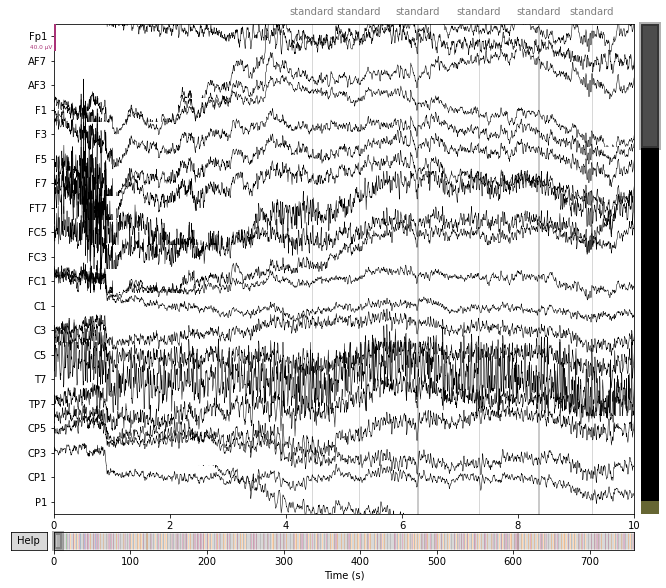

In [155]:
# Visualize the raw data
%matplotlib inline
raw.plot();

## Select only a subset of the channels

In [23]:
# Number of channels before subsetting
len(raw.ch_names)

79

In [133]:
# Show all channels before subsetting
', '.join(raw.ch_names)

'Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5, P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6, FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2, EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, GSR1, GSR2, Erg1, Erg2, Resp, Plet, Temp'

In [157]:
# Select only a subset of the channels
raw_eeg = raw.copy()
raw_eeg.pick_types(meg = False, eeg = True, eog = True, exclude = [])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 65 x 194048 (758.0 s), ~96.3 MB, data loaded>

In [156]:
# Number of channels after subsetting
len(raw_eeg.ch_names)

65

In [154]:
# Show the subset of the channels
', '.join(raw_eeg.ch_names)

'Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, T7, TP7, CP5, CP3, CP1, P1, P3, P5, P7, P9, PO7, PO3, O1, Iz, Oz, POz, Pz, CPz, Fpz, Fp2, AF8, AF4, AFz, Fz, F2, F4, F6, F8, FT8, FC6, FC4, FC2, FCz, Cz, C2, C4, C6, T8, TP8, CP6, CP4, CP2, P2, P4, P6, P8, P10, PO8, PO4, O2, Temp'

## Visualize the sensor locations

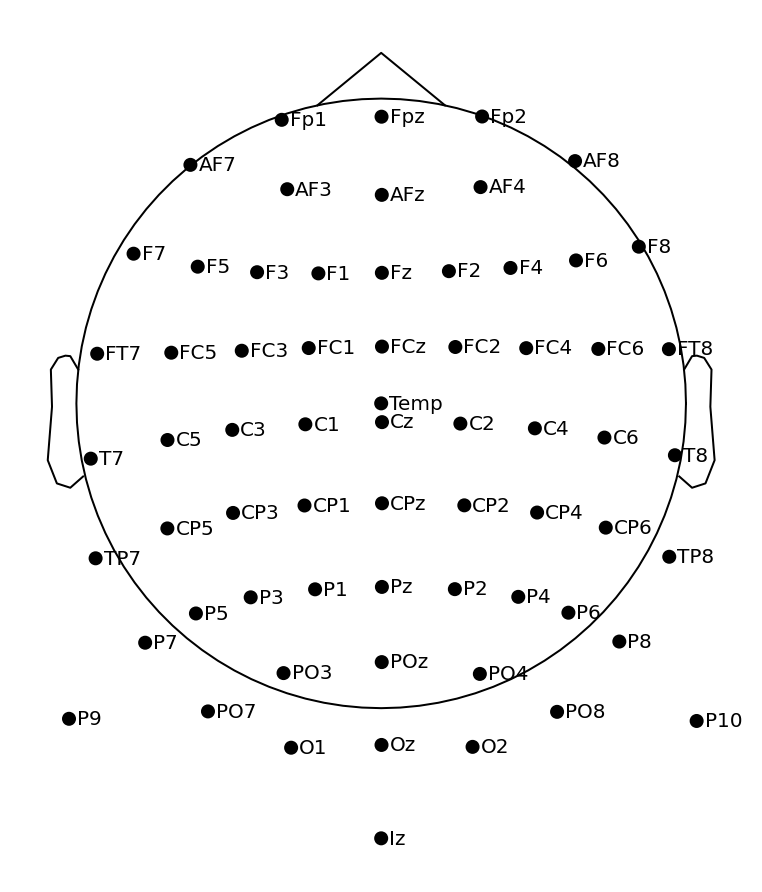

In [134]:
# In 2D
mne.viz.plot_sensors(raw.info, kind = 'topomap', ch_type = 'all', show_names = True)

## Referencing
We choose T7 and T8 as our referenced electrodes for our data. (Since there are no M1 and M2 channels in our data.)

In [124]:
# Referencing using the T7, T8 channels as the referenced electrode
raw_ref = raw_eeg.copy()
raw_ref.set_eeg_reference(ref_channels = ['T7', 'T8'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEEGLAB | sub-001_task-P300_run-1_eeg.set, 65 x 194048 (758.0 s), ~96.3 MB, data loaded>

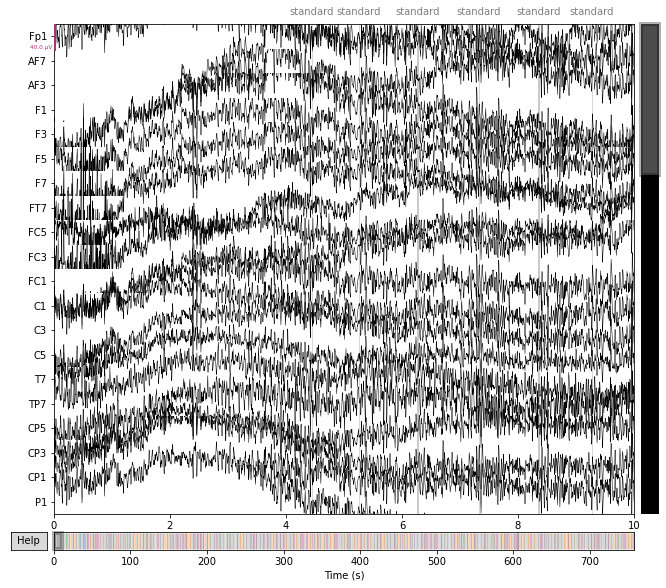

In [159]:
raw_ref.plot();

## Filtering

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


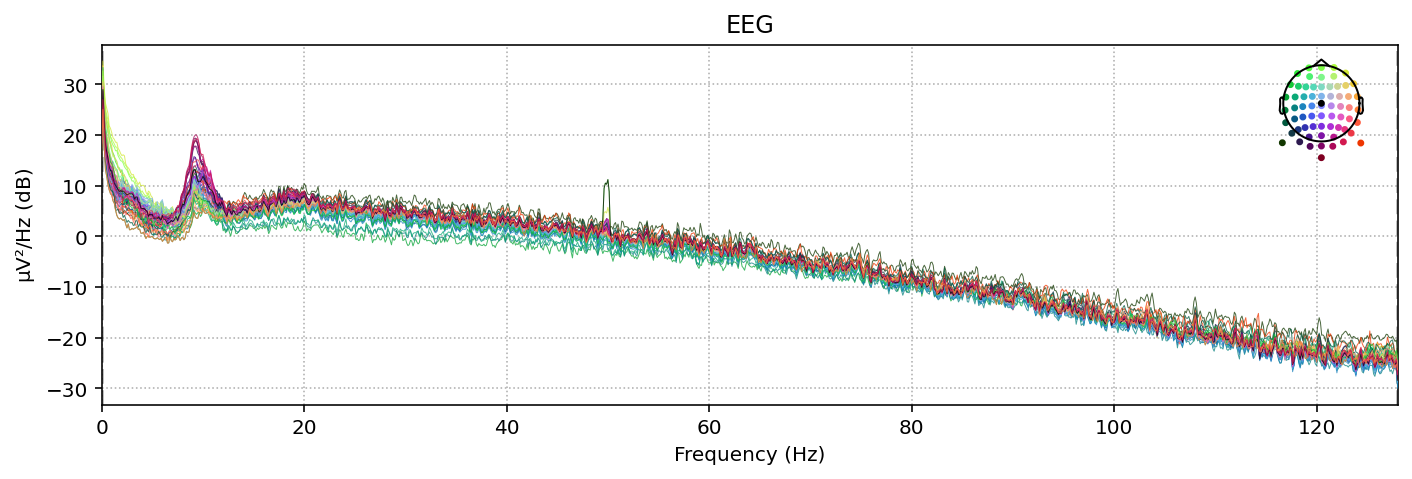

In [138]:
# Plot the power spectrum before filtering
raw_ref.plot_psd()

In [139]:
# Using a band pass filter from 1-30 Hz
raw_filtered = raw_ref.copy()
raw_filtered = raw_filtered.filter(l_freq = 1, h_freq = 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.3s finished


### Compare before and after filtering

In [140]:
fig, ax = plt.subplots(2, figsize = (10,5))

# Plot PSD before filtering
raw_ref.plot_psd(ax = ax[0], picks = ['eeg'], show = False)
ax[0].set_title('PSD before filtering')

# Plot PSD after filtering
raw_filtered.plot_psd(ax = ax[1], picks = ['eeg'], show = False)
ax[1].set_title('PSD after filtering')

# Set x-axis label
ax[1].set_xlabel('Frequency (Hz)')

# Adjust layout and show the figure
fig.tight_layout()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


<ipython-input-140-1b5608bb4d25>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


### Zoom in 

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


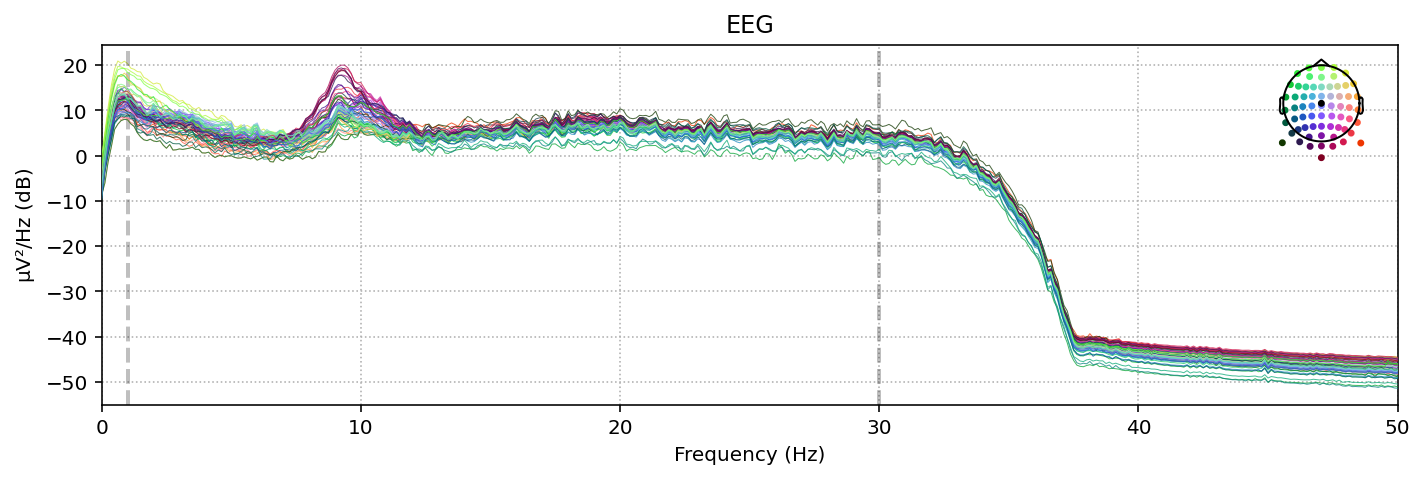

In [141]:
raw_filtered.plot_psd(fmax = 50)

## Extract events from annotations

In [143]:
# Get events and event ids from annotations
events, event_id = mne.events_from_annotations(raw_filtered)

Used Annotations descriptions: ['ignore', 'noise', 'noise_with_reponse', 'oddball', 'oddball_with_reponse', 'response', 'standard']


## Creating epochs for the events

In [144]:
# Epochs will start 300 ms before the stimulus onset and end 
# 500 ms after stimulus onset
tmin = -0.2
tmax = 0.6
baseline = (None, 0)

epochs = mne.Epochs(raw,
                    events = events,
                    event_id = event_id,
                    tmin = tmin,
                    tmax = tmax,
                    baseline = baseline,
                    preload = True)
epochs

Not setting metadata
863 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 863 events and 206 original time points ...
1 bad epochs dropped


Number of events,862
Events,ignore: 3noise: 111noise_with_reponse: 1oddball: 1oddball_with_reponse: 112response: 113standard: 521
Time range,-0.199 – 0.602 s
Baseline,-0.199 – 0.000 s


In [145]:
epochs.plot();

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


Not setting metadata
521 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


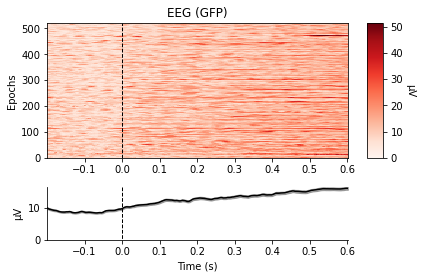

[<Figure size 432x288 with 3 Axes>]

In [146]:
%matplotlib inline
epochs['standard'].plot_image()

Not setting metadata
112 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


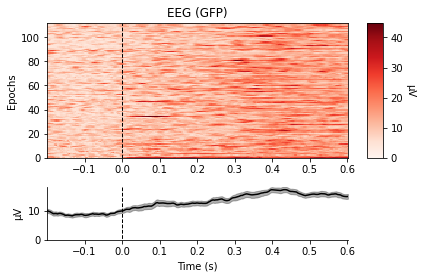

[<Figure size 432x288 with 3 Axes>]

In [147]:
%matplotlib inline
epochs['oddball_with_reponse'].plot_image()

## Creating evoked data

Creating evoked responses for each condition

In [148]:
evoked_standard = epochs['standard'].average()
evoked_oddball_resp = epochs['oddball_with_reponse'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


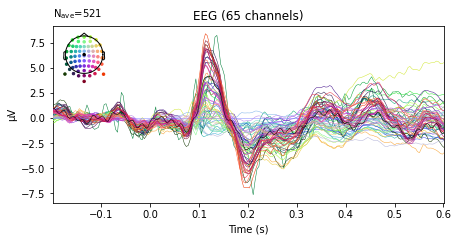

In [149]:
evoked_standard.plot(spatial_colors = True);

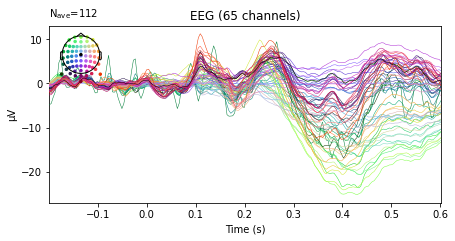

In [150]:
evoked_oddball_resp.plot(spatial_colors = True);

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


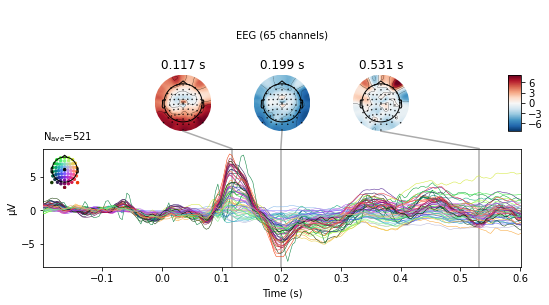

In [151]:
evoked_standard.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


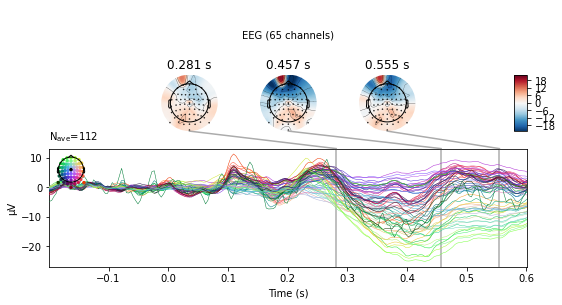

In [152]:
evoked_oddball_resp.plot_joint();

combining channels using "gfp"
combining channels using "gfp"


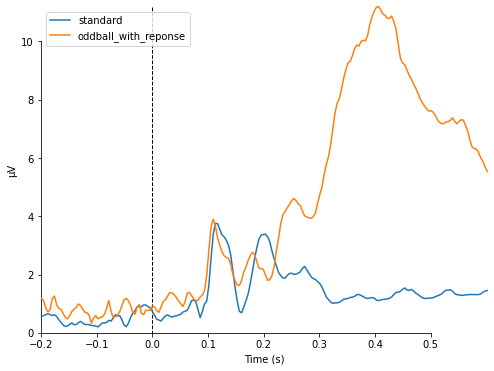

In [153]:
mne.viz.plot_compare_evokeds([evoked_standard, evoked_oddball_resp]);

## Fitting and plotting ICA

In [103]:
n_components = 15
method = 'infomax'
max_iter = 500 
random_state = 42

ica = mne.preprocessing.ICA(n_components = n_components,
                            method = method,
                            max_iter = max_iter,
                            random_state = random_state)
ica.fit(epochs)

Fitting ICA to data using 65 channels (please be patient, this may take a while)


<ipython-input-103-62b7e3e7e4a1>:10: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs)
<ipython-input-103-62b7e3e7e4a1>:10: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 15 components
 
Fitting ICA took 18.3s.


Method,infomax
Fit,500 iterations on epochs (177572 samples)
ICA components,15
Available PCA components,65
Channel types,eeg
ICA components marked for exclusion,—


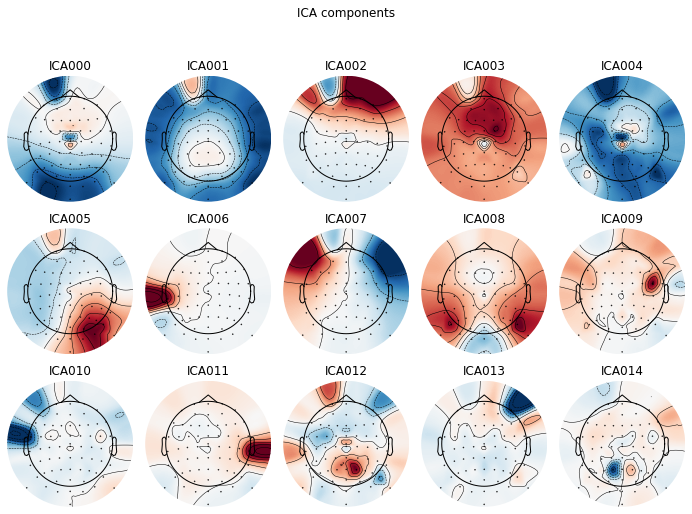

[<MNEFigure size 702x526.68 with 15 Axes>]

In [104]:
ica.plot_components(inst = epochs)

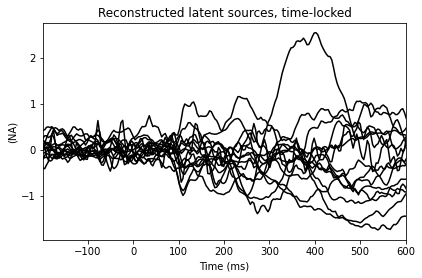

In [105]:
ica.plot_sources(evoked_oddball_resp);

Using EOG channel: Fp1
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


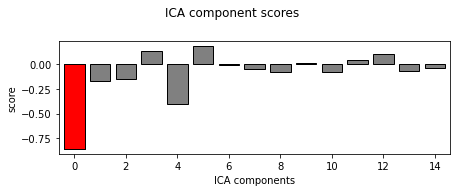

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
379 matching events found
No baseline correction applied
0 projection items activated


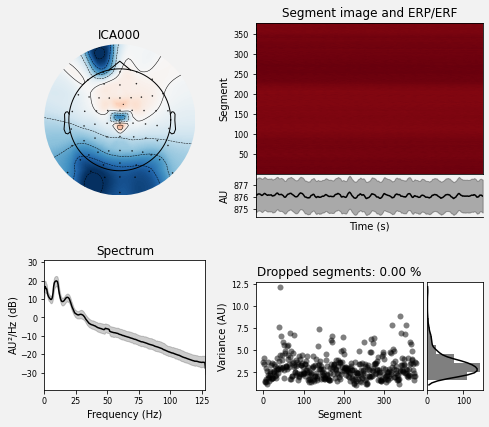

Creating RawArray with float64 data, n_channels=15, n_times=194048
    Range : 0 ... 194047 =      0.000 ...   757.996 secs
Ready.


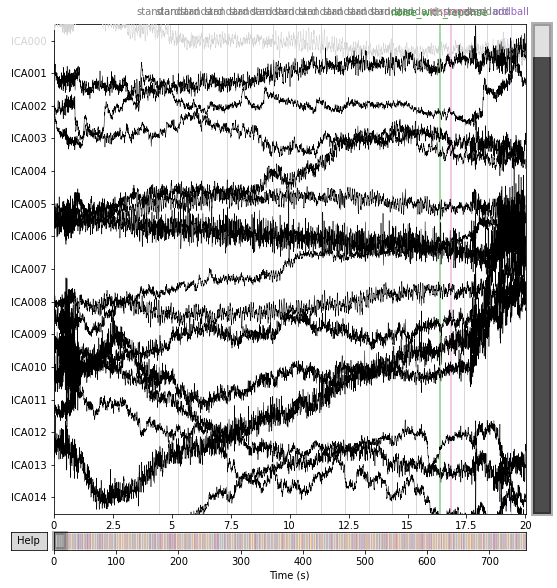

In [107]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name = "Fp1")
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores);

# plot diagnostics
ica.plot_properties(raw, picks = eog_indices);

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw);